# Gaussian graphical models

Here, we implement the *graphical Lasso* for sparse precision matrix estimation of a Gaussian graphical model. The [graphical Lasso](https://cran.r-project.org/web/packages/glasso/index.html) was [published here](https://academic.oup.com/biostatistics/article/9/3/432/224260) by Friedman, Hastie and Tibshirani.

In Gaussian graphical models the underlying joint distribution of a random vector $Y$ is a multivariate Gaussian:

\begin{align} P(\mathbf{y}) & \propto \exp \left( -\frac{1}{2} \mathbf{y}^T \boldsymbol \Lambda \mathbf{y} + (\boldsymbol \Lambda \boldsymbol \mu)^T \mathbf{y} \right), 
\end{align}

where $\boldsymbol \Lambda$ is the precision matrix and $\boldsymbol \mu$ the mean vector of the Gaussian. The undirected graph that encodes the conditional independence relations is in the Gaussian case naturally interpreted, since an existing edge $e_{ij}$ encodes that the partial correlation $\Lambda_{ij} \ne 0$. That means: 

$$ Y_i \ \bot \ Y_j \ \mid Y_{-ij} \Leftrightarrow \Lambda_{ij} = 0.$$

In order to estimate $\boldsymbol \Lambda$ we set up the semi-definite program: the graphical Lasso. The graphical Lasso tries to maximize the following $\ell_1$-regularized log-likelihood: $$ \log \det \boldsymbol \Lambda - \text{tr}(S \boldsymbol \Lambda) - \alpha || \boldsymbol \Lambda ||_1 $$

Let's implement this. First we load some libraries.

In [1]:
library(glmnet)
library(MASS)
library(Matrix)
library(ggplot2)
library(reshape2)
library(dplyr)
library(colorspace)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16


Attaching package: ‘dplyr’

The following object is masked from ‘package:MASS’:

    select

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Set up some constants like the number of samples $n$, the number of covariates $p$, the regulariztion parameter $\lambda$ and a maximal number of iterations.

In [2]:
n <- 1000
p <- 10
lambda <- .1
maxit <- 100

Create the precision matrix $\boldsymbol \Lambda$.

In [3]:
set.seed(1)
A <- rsparsematrix(p, p, 0.15, rand.x = rnorm)
Lambda <- A %*% t(A) + 0.05 * diag(p)

Create the covariance matrix $\boldsymbol \Sigma = \boldsymbol \Lambda^{-1}$.

In [4]:
Sigma <- as.matrix(solve(Lambda))
Sigma <- Sigma / max(Sigma)

Create an artificial data-set.

In [5]:
X <- MASS::mvrnorm(n, rep(0, p), Sigma)

.. and finally this is the implementation of the graphical Lasso. It is rather easy to implement. It basically requires subsetting the current estimate of the covariance matrix $\boldsymbol W$ and the empirical covariance $\boldsymbol S$ and then fitting of a LASSO-model to these. We then update our estimated covariance matrix $\boldsymbol W$. In addition we estimate a precision matrix $\boldsymbol P = \hat{\boldsymbol \Lambda}$. The original implementation is slightly different, I believe.

For computing the LASSO itself, we use `glmnet`. We could implement this ourselves, too, but for efficiency and speed this suffices. For anyone interested: LASSO computes a soft-thresholded (normalized) estimate of the partial residual with every iteration and is thus not too hard to implement.

In [6]:
S <- cov(X)
W <- S + lambda*diag(p)
P <- diag(p)
for (i in seq(maxit)) 
{
    for (pi in seq(p)) 
    {
        # Get submatrices W and S
        W_11 <- W[-pi, -pi]
        S_12 <- S[pi, -pi]
        # Lasso
        beta <- as.vector(
            glmnet(W_11, S_12, lambda = lambda, alpha = 1)$beta
        )
        # update W
        W[pi, -pi] <- W[-pi, pi] <- W_11 %*% beta
        # update precision
        P[pi, pi] <- 1 / (W[pi, pi] - W[-pi, pi] %*% beta)
        P[-pi, pi] <- P[pi, -pi] <- -P[pi, pi] * beta
    }
}

Let's plot what we got.

In [7]:
W     <- cbind(Type="Estimated Covariance", reshape2::melt(W))
Sigma <- cbind(Type="True Covariance", reshape2::melt(Sigma))

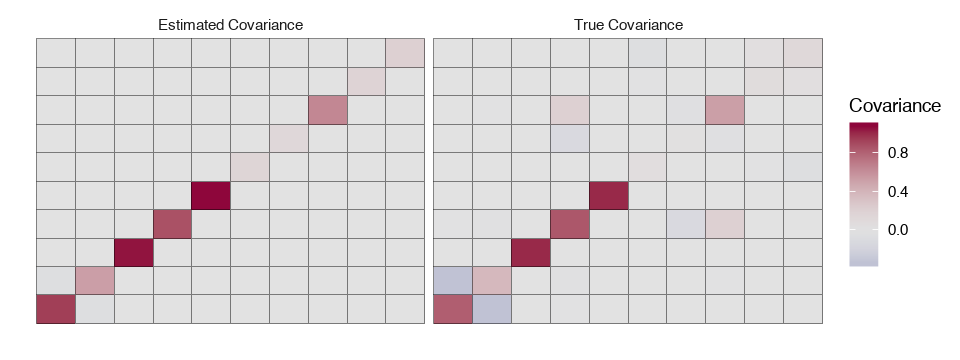

In [8]:
options(repr.plot.width=8, repr.plot.height=3)
rbind(W, Sigma) %>%
    ggplot() +
    geom_tile(aes(Var1, Var2, fill=value), color="black") +
    scale_fill_continuous_diverging(name="Covariance", mid=0) +
    facet_grid(. ~ Type) +
    scale_x_continuous("", expand=c(0,0)) +
    scale_y_continuous("", expand=c(0,0)) +
    theme_minimal() +
    theme(axis.text = element_blank(),
          axis.ticks = element_blank())

Doesn't look to bad, but we have dealt with a very easy scenario with a lot of data and hardly any regularization needed.